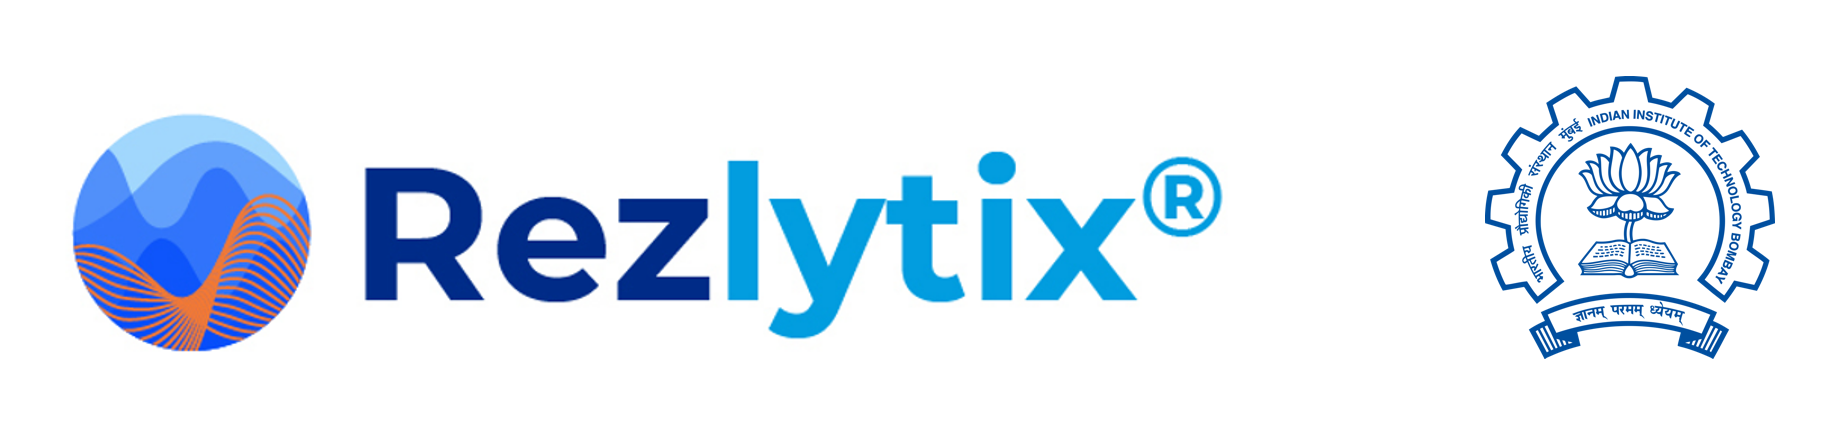

# Data Loading and Visualization


## Notebook overview

*   Introduction - What is E&P data?

*   Data Loading  
  *   Loading Seismic Data
  *   The XArray Format
  *   Seismic Data Visualization
  *   Loading well logs.
  *   Well log Visualization

-----

## Exploration & Production data: A quick reprisal

The O & G industry has dealt with large amounts of data for several years now, and in a way is the original "Big Data" industry. 
Some of the major data generated / used during E & P activities include:

*   Seismic data
*   Well log data
*   Well Production data
*   Gravity & Magnetic data
*   Remote Sensing Data
*   etc.

We shall focus on **seismic & well log** data in this session.



### Seismic Data

**Acquisition - 2D seismic survey** 

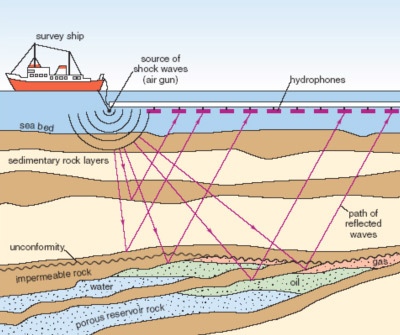

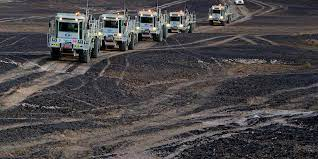

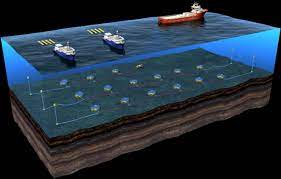

**Typical seismic section**

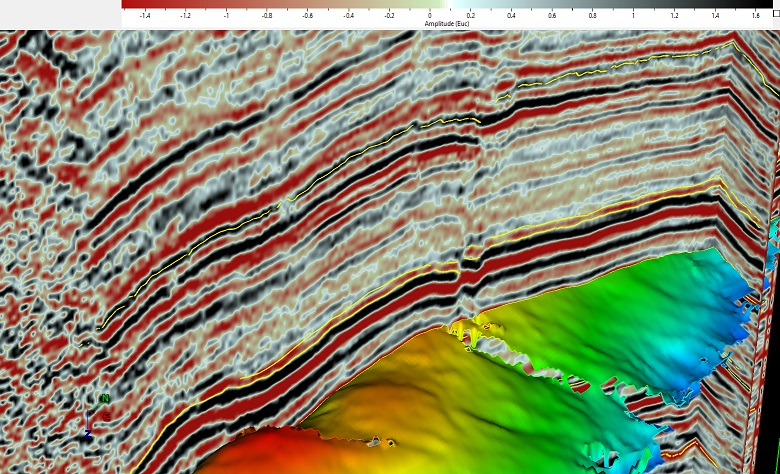

* Seismic data is typically available in the industry standard SEG-Y format, which includes headers (or metadata).
    * EBCDIC or Textual header (3200 bytes): Contains human readable description about the data.
    * Binary headers (400 bytes): Numerical data pertaining to all data within the file.
    * Trace headers (240 bytes): Numerical (integer) information for each individual trace.
    * Trace data: The actual recorded digital seismic data, which we are interested in analyzing.
    * Optional extended textual headers (3200 bytes each)

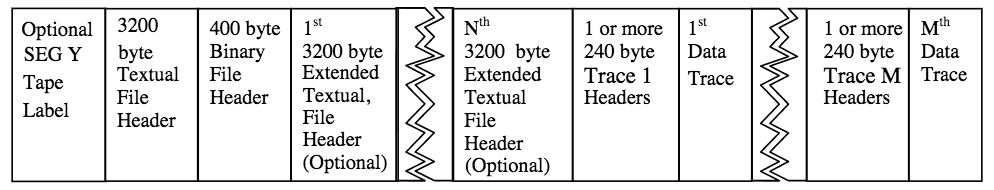
  
* Can be 2D / 3D data.<br>
* **While SEG-Y data is an excellent and standardized format for data transfer between entities, it is not suitable for numerical analysis, machine learning tasks, etc.**<br>
* Hence, we need to convert it to a suitable format.<br><br>

Our format of choice for numerical analysis and ML applications is XArray.
<br><br>
We shall use **SEGYSAK** to load SEG-Ys.<br>
https://segysak.readthedocs.io/en/latest/

## Data Loading

In [ ]:
##### Applicable only if you are running this notebook on Colab. Disble otherwise.
##### Mount your google drive to this notebook. It will require some permissions.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Define base working directory for this session. Same as the one created earlier.
import os
base_dir = "/content/drive/My Drive/<Your_folder_name>"     # Please change path / folder name as required. 

if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

if not os.path.isdir(base_dir + "/loaded"):
    os.mkdir(base_dir + "/loaded")

os.chdir(base_dir)

**Please ensure that the sample data folder (workshop_data) that we have provided is inside this base directory.**

### Required libraries

Let's first get all the required libraries.
Since some of these have fairly specific / limited usage, they are usually not part of the standard set of libraries already installed within Colab.

In [ ]:
# Imports for JupyterLite
%pip install -q ipywidgets

In [ ]:
# Let's first install a few uncommon libraries to this environment.
!pip install lasio
!pip install wget
!pip install bresenham
!pip install segyio
!pip install segysak
!pip install pydantic

Other common libraries you will need in this notebook. Please install them if you don't already have them. These come pre-installed in Colab.

* numpy
* scipy
* pandas
* matplotlib
* seaborn
* plotly

In [ ]:
# Scientific and data analysis libraries

import pandas as pd
import numpy as np
import numpy.linalg as LA
from numpy.polynomial.polynomial import polyfit
import xarray as xr
import math
from math import sqrt

import scipy
from scipy import interpolate as interp
from scipy.interpolate import CloughTocher2DInterpolator, griddata
from scipy import signal
from scipy.signal import savgol_filter, correlate, coherence, hilbert, periodogram, welch, butter, lfilter
from scipy.spatial import KDTree, cKDTree, distance
from scipy.fftpack import ifft,fftshift,fft
from scipy.ndimage import gaussian_filter1d
from scipy.stats import pearsonr
import bresenham
from bresenham import bresenham
from functools import reduce

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as transforms
from matplotlib import gridspec
from matplotlib.pyplot import cm
from matplotlib.cbook import flatten
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as ipyw

# Typesafe coding
from pydantic import BaseModel, Field
from typing import Any, Optional,List, Union
from typing import Dict, Union
from typing_extensions import Annotated, Literal

# Generic libraries
import os
import time
import shutil
from shutil import copyfile
import warnings

warnings.filterwarnings("ignore")

mpl.rc('font', size=20)
%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.3f}'.format

------

In [ ]:
segyfile = base_dir + '/workshop_data/seismic/Sample_3d_seismic_data.segy'

In [ ]:
# Required libraries for SEG-Y loading
import segyio
import segysak
from segysak import segy
from segysak.segy import segy_loader, segy_header_scrape, well_known_byte_locs

**Let's first have a quick look at the headers. They give you more insight into the data, before actually viewing it.**

#### SEGY headers investigation

In [ ]:
# Inspect EBCDIC header
segy.get_segy_texthead(segyfile)

In [ ]:
# Binary Header
segy.segy_bin_scrape(segyfile)

In [ ]:
# pd.set_option('display.max_rows', 100)

In [ ]:
# Inspect summary of trace headers 
segy.segy_header_scan(segyfile)

#### Loading Seismic Data



In [ ]:
# First we define and typesafe the objects we need for SEG-Y loading

class LoadSEGYSettings(BaseModel):
    file_type:  Literal['3d_poststack','2d_poststack','3d_image_gathers','2d_image_gathers','3d_shot_gathers','2d_shot_gathers']
    domain:     Literal['time', 'depth']
    datum:      Literal['msl','lat']
    vol_type:   Literal['seismic','velocity_int','velocity_rms','acoustic_impedance','lfm','storm','strike']
    byte_x:     int                   # Starting byte in Trace headers for CDP_X
    byte_y:     int                   # Starting byte in Trace headers for CDP_Y
    byte_iline: int                   # Starting byte in Trace headers for Inline number
    byte_xline: int                   # Starting byte in Trace headers for Crossline number
    
class LoadSEGYInput(BaseModel):
    path:       str                   # Path of the SEG-Y data
    file_id:    Optional[str]         # Note how this is an optional entry
    name:       Optional[str]                     
    
class LoadSEGYOutput(BaseModel):
    path:       str                   # Output path
    surveyfile_path: str
    name:       str                   # Output name
    description: Optional[str]        # Optional description

class LoadSEGYJobConfig(BaseModel):
    input:      LoadSEGYInput
    output:     LoadSEGYOutput
    settings:   LoadSEGYSettings

* We shall use the "segysak" library to convert SEG-Y data to an Xarray, specifically the 'segy_loader' command.
* Segysak also has several other methods to inspect a SEG-Y file without actually loading it. This can be used to identify some of the input settings, which may vary between different files.

In [ ]:
# Code to load 3d seismic data
class Load3DSEGY:
    @staticmethod
    def run(config: LoadSEGYJobConfig):
        vertical_domain = 'TWT'
        if config.settings.domain == 'depth':
            vertical_domain = 'DEPTH'

        # SEGYSAK's segy_loader loads the SEG-Y file and creates an xarray. 
        segy_xr = segy_loader(segyfile = config.input.path,
                              cdpx =     config.settings.byte_x,
                              cdpy =     config.settings.byte_y,
                              iline =    config.settings.byte_iline,
                              xline =    config.settings.byte_xline,
                              vert_domain=vertical_domain
                            )
        
        for attribute in segy_xr.attrs:             # The xarray format allows attributes (or metadata) to be saved along with the actual data.
            if segy_xr.attrs[attribute] is None:
                segy_xr.attrs[attribute] = 0
        segy_xr.attrs['domain'] = vertical_domain
        segy_xr.attrs['datum'] = config.settings.datum

        survey_file_df = segy_header_scrape(segyfile = config.input.path,              # Scraping specific trace headers from each trace, and creating a dataframe with each row representing 1 trace.
                                            bytes_filter=[config.settings.byte_x, 
                                                          config.settings.byte_y,
                                                          config.settings.byte_iline,
                                                          config.settings.byte_xline]
                                            )
        survey_file_df.index.name = 'Trace'
        survey_file_df.reset_index(inplace=True)
        survey_file_df.columns=['Trace','cdp_x','cdp_y','iline','xline']

        coord_scalar = segy_xr.coord_scalar                          # This is a multiplication factor for the X, Y coordinates and is stored in the SEG-Y trace headers.
        survey_file_df['cdp_x'] = survey_file_df['cdp_x'] / int(abs(coord_scalar))
        survey_file_df['cdp_y'] = survey_file_df['cdp_y'] / int(abs(coord_scalar))
        
        survey_file_df = survey_file_df[['Trace','cdp_x','cdp_y','iline','xline']]
        survey_file_df.to_csv(config.output.surveyfile_path, index = False)     # Export dataframe to a csv file
        # segy_xr.attrs['survey_file'] = config.output.surveyfile_path
        
        segy_xr.to_netcdf(config.output.path)                              # Exporting the xarray to a netcdf (.nc) file, which is the default method of storing xarray data.

In [ ]:
# Code to load 3d seismic data
def load_segy(config: LoadSEGYJobConfig):
    vertical_domain = 'TWT'
    if config.settings.domain == 'depth':
        vertical_domain = 'DEPTH'

    # SEGYSAK's segy_loader loads the SEG-Y file and creates an xarray. 
    segy_xr = segy_loader(segyfile = config.input.path,
                          cdpx =     config.settings.byte_x,
                          cdpy =     config.settings.byte_y,
                          iline =    config.settings.byte_iline,
                          xline =    config.settings.byte_xline,
                          vert_domain=vertical_domain
                        )
    
    for attribute in segy_xr.attrs:             # The xarray format allows attributes (or metadata) to be saved along with the actual data.
        if segy_xr.attrs[attribute] is None:
            segy_xr.attrs[attribute] = 0
    segy_xr.attrs['domain'] = vertical_domain
    segy_xr.attrs['datum'] = config.settings.datum

    survey_file_df = segy_header_scrape(segyfile = config.input.path,              # Scraping specific trace headers from each trace, and creating a dataframe with each row representing 1 trace.
                                        bytes_filter=[config.settings.byte_x, 
                                                      config.settings.byte_y,
                                                      config.settings.byte_iline,
                                                      config.settings.byte_xline]
                                        )
    survey_file_df.index.name = 'Trace'
    survey_file_df.reset_index(inplace=True)
    survey_file_df.columns=['Trace','cdp_x','cdp_y','iline','xline']

    coord_scalar = segy_xr.coord_scalar                          # This is a multiplication factor for the X, Y coordinates and is stored in the SEG-Y trace headers.
    survey_file_df['cdp_x'] = survey_file_df['cdp_x'] / int(abs(coord_scalar))
    survey_file_df['cdp_y'] = survey_file_df['cdp_y'] / int(abs(coord_scalar))
    
    survey_file_df = survey_file_df[['Trace','cdp_x','cdp_y','iline','xline']]
    survey_file_df.to_csv(config.output.surveyfile_path, index = False)     # Export dataframe to a csv file
    # segy_xr.attrs['survey_file'] = config.output.surveyfile_path
    
    segy_xr.to_netcdf(config.output.path)                              # Exporting the xarray to a netcdf (.nc) file, which is the default method of storing xarray data.

In [ ]:
# Defining settings
settings = LoadSEGYSettings(file_type = '3d_poststack',
                            domain = 'time',
                            datum = 'msl',
                            vol_type = 'seismic',
                            byte_x = 181,
                            byte_y = 185,
                            byte_iline = 189,               
                            byte_xline = 193
                            )   

In [ ]:
# Defining inputs
input = LoadSEGYInput(path=segyfile)

In [ ]:
# Defining outputs
out_file_name = "seis_xr_sample1"
out_path = base_dir + '/loaded/' + out_file_name + '.nc'
survey_path = base_dir + '/loaded/' + out_file_name + '_survey.csv'

output = LoadSEGYOutput(path = out_path,
                        surveyfile_path = survey_path,
                        name = out_file_name,
                        description = "Loading SEG-Y file to Xarray")

In [ ]:
# Defining SEGY load config
config = LoadSEGYJobConfig(input = input, 
                           output = output, 
                           settings = settings)

In [ ]:
Load3DSEGY.run(config=config)

In [ ]:
load_segy(config=config)

In [ ]:
# Open the xarray that has just been created
seis_xr = xr.open_dataset(out_path)
seis_xr

**Your SEG-Y data should now have been converted to XArray format**
<br><br>
It may seem that the above process is a bit convoluted. You may ask why don't we use the "segy_loader" function directly in one line. <br>
The reason: **Repeatable** and **Typesafe** code.<br><br>


#### Exercise - Your turn

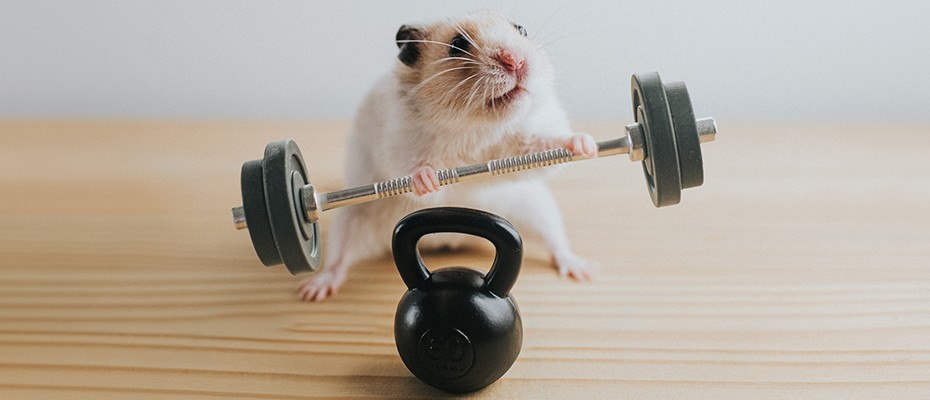

In [ ]:
velfile = base_dir + '/workshop_data/seismic/Sample_3d_velocity_data.segy'

Load the 3d rms velocity from the above location to an XArray.

In [ ]:
# You need to set 'input', 'output' & 'settings', and combine them into a config object.











In [ ]:
# Load the SEG-Y to an Xarray using the above config parameters






----

### Seismic Data Visualisation

**A picture speaks a thousand words... or in our case, millions of numbers.**

* Visualization of any data is an integral part of any workflow, before proceeding with any kind of analysis or algorithm.
* More importantly, it is a quick check on whether the data has been loaded in a suitable manner, and without errors.

#### Basemap

An aerial view of the survey area.

In [ ]:
# Remember the survey file csv created during the SEG-Y loading process. Let's load it back as a dataframe.
surveyfile_path = base_dir + '/loaded/' + out_file_name + '_survey.csv'
survey_file_df = pd.read_csv(surveyfile_path)
survey_file_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=np.array(survey_file_df['cdp_x']),y=np.array(survey_file_df['cdp_y']))
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('BaseMap',weight='bold', fontsize=20)
plt.show()

#### Visualizing 2d slices

In [ ]:
# Let's first reload the xarray we had created earlier
file_name = "seis_xr_sample"
file_path = base_dir + '/loaded/' + file_name + '.nc'
seis_xr = xr.open_dataset(out_path)
seis_xr

In [ ]:
# Slice an inline from the data
il_slice = seis_xr.sel(iline = 10000)
il_slice

In [ ]:
# Let's plot it now. We shall use plotly express for this. have some 
px.imshow(img = il_slice.data.T, 
          color_continuous_scale='gray', zmin=-0.2, zmax = 0.2,            # Define the colourscale, and the range of the display
          width = 1200, height = 700, aspect = 'auto',                     # Define the size of the display   
          title = '2D Seismic section Inline 10000'
          )

**Can you tell why did we have to transpose the data?**

Also, notice how plotly automatically obtains the axis labels from the dimensions of the data.



In [ ]:
def slice_2d_viewer(xr_data, 
                    slice_type: str, 
                    slice_value: float, 
                    colourscale: str = 'gray', 
                    clr_min: float = -0.5, 
                    clr_max: float = 0.5):
    
    # Write your solution below
    if slice_type.lower() == 'inline':
        slice = xr_data.sel(inline = slice_value)
    elif slice_type.lower() == 'xline':
        slice = xr_data.sel(xline = slice_value)
    else:
        slice = xr_data.sel(twt = slice_value)
    img = px.imshow(img = slice.data.data.T, 
              color_continuous_scale = colourscale, zmin = clr_min, zmax = clr_max,
              width = 1200, height = 700, aspect = 'auto',
              title = slice_type[0].upper() + slice_type[1:] + " " + str(slice_value)
              )
    return img    

In [ ]:
slice_2d_viewer(xr_data = seis_xr, slice_type = 'xline', slice_value = 2000, colourscale = 'RdGy', clr_min = -0.1, clr_max = 0.1)

__________

### Well Log Data

As with seismic data, we shall load well log data to the xarray format, while maintaining the DRY principles and writing Typesafe code.
<br>
Our library of choice for dealing with las files is 'lasio'.<br>
https://lasio.readthedocs.io/en/latest/
<br><br>


In [ ]:
import lasio

#### Investigating LAS files

LAS files also have headers, containing metadata about the well logs: log mnemonics, units, descriptions, location data, datums (KB), etc.<br><br>
The actual data is keyed off "DEPTH" values.

In [ ]:
# Defining a function to see a summary of the contents of a LAS file. 
def well_las_summary(well_name: str):
    well_path: str = base_dir + '/workshop_data/las/' + str(well_name) + '_logs.las'
    well_las = lasio.read(str(well_path))

    columns_to_show: list = ['original_mnemonic', 'mnemonic', 'unit', 'descr']
    las_curves_df = pd.DataFrame.from_records([x.__dict__ for x in well_las.curves])[columns_to_show]
    headers_df = pd.DataFrame.from_records([x.__dict__ for x in well_las.well])   

    return las_curves_df, headers_df 

In [ ]:
df1, df2 = well_las_summary(well_name = '15_9-F-11A')

In [ ]:
df1

#### Loading Well Log Data

In [ ]:
# Define the list of log mnemonics we shall work with for this session.
logs: list[str] = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT','DTS']

In [ ]:
class LoadWellLASSettings(BaseModel):
    depth_mnem:   str = 'DEPTH'                 # Depth mnemonic
    logs_to_load: list[str] = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'DTS']    # list of log mnemonics we want to work with

class LoadWellLASInput(BaseModel):
    name:       Optional[str]
    well_name:  str
    path:       str
    file_id:    Optional[str]

class LoadWellLASOutput(BaseModel):
    name:       Optional[str]
    path:       str
    description:Optional[str]

class LoadWellLASJobConfig(BaseModel):
    input:      LoadWellLASInput
    output:     LoadWellLASOutput
    settings:   LoadWellLASSettings

In [ ]:
# Code to load LAS files
class LoadWellLAS:
    def run(config: LoadWellLASJobConfig):
        las_path: str = config.input.path
        well_name: str = config.input.well_name

        depth_mnem: str = config.settings.depth_mnem
        logs_to_load: list[str] = config.settings.logs_to_load

        # Read las and convert to a dataframe
        las_df = lasio.read(las_path)
        las_df = las_df.df()
        las_df.reset_index(inplace=True)
        las_df.set_index(depth_mnem, inplace=True)        

        las_cols = las_df.columns.tolist()

        # Include only logs that we need and are available
        available = [mnemonic for mnemonic in logs_to_load if mnemonic in las_cols]
        las_df = las_df[available]
        # las_df.reset_index(inplace=True, drop=True)        

        las_xr = las_df.to_xarray()

        for attribute in las_xr.attrs:
            if las_xr.attrs[attribute] is None:
                las_xr.attrs[attribute] = 0
        
        las_xr.attrs["Well"] = well_name

        las_xr.to_netcdf(config.output.path)                

In [ ]:
# Function to load multiple wells simultaneously

def load_well_las(well_filename: str, 
                  base_las_dir: str):
    # Define settings
    settings = LoadWellLASSettings(depth_mnem = 'DEPTH',
                                  logs_to_load = logs)

    well = well_filename[:-9]

    # Define input
    input = LoadWellLASInput(well_name = well,
                             path = base_las_dir + well + "_logs.las")

    # Define output
    out_file_name = well + '_LAS.nc'
    out_path = base_dir + '/loaded/' + out_file_name 
    output = LoadWellLASOutput(name = out_file_name,
                               path = out_path,
                               description= "Loading LAS " + well)

    # Define config
    config = LoadWellLASJobConfig(input = input,
                                  output = output,
                                  settings = settings)

    LoadWellLAS.run(config=config)

#### Exercise

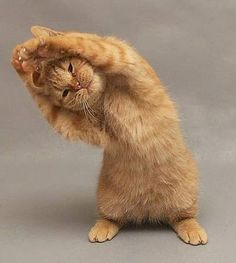


* Create a function to view a 2d slice of data, when supplied with the following information:

    * Xarray Data
    * Type of slice (inline, crossline, timeslice)
    * Slice value
    * Colourscale
    * Colour range (Min, Max)

In [ ]:
# Exercise: Load all the well log data in the 'las' directory
base_las_dir = base_dir + '/workshop_data/las/'
all_wells = os.listdir(base_las_dir)

# Write your code below


In [ ]:
all_wells

### Well Log Visualization

In [ ]:
well='15_9-F-1A'  #well to be loaded
well_file_name = well + '_LAS.nc'
well_file_path = base_dir + '/loaded/' + well_file_name 

well_xr = xr.open_dataset(well_file_path)
well_df = well_xr.to_dataframe()
well_df

In [ ]:
well_xr

In [ ]:
logs = well_df.columns.to_list()
logs

In [ ]:
def well_log_plot(well_df, logs):
  z=len(logs)+1

  fig,ax=plt.subplots(figsize=(40,40))

  count = 0
  depth = well_df.index

  for log in logs:

      if log=='CALI':
          count+=1
          ax1=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1)
          
          ax1.plot(well_df[log], depth, color = "red", linewidth = 0.5)
          
          ax1.set_xlabel("Cali")  
          ax1.set_ylabel("Depth (m)")      
          ax1.xaxis.label.set_color("red")
          ax1.set_xlim(5,10)

          ax1.tick_params(axis='x', colors="red")
          
          ax1.set_xticks([5,10])
          ax1.grid(which='major', color='lightgrey', linestyle='-')
          
          ax1.xaxis.set_ticks_position("top")
          ax1.xaxis.set_label_position("top")
          
          ax1.spines["top"].set_position(("axes", 1.02))
          ax1.spines["top"].set_edgecolor("red")

  for log in logs:    
      if log=='GR':
          count+=1
          ax2=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1, sharey = ax1)

          curve=well_df[log]

          left_col_value = curve.min()
          right_col_value = curve.max()

          span = abs(left_col_value - right_col_value)

          ##assigning a color map
          cmap = plt.get_cmap('nipy_spectral')  

          ##create array of values to divide up the area under curve
          color_index = np.arange(left_col_value, right_col_value, span / 100)

          ax2.plot(curve, depth, color = "black", linewidth = 0.5)

          for index in sorted(color_index):
              index_value = (index - left_col_value)/span
              color = cmap(index_value) #obtain colour for color index value
              ax2.fill_betweenx( depth, 0 , curve, where = curve >= index,  color = color)


          ax2.set_xlabel("GR")
          ax2.xaxis.label.set_color("green")
          ax2.set_xlim(left_col_value, right_col_value)        

          ax2.tick_params(axis='x', colors="green") 

          ax2.title.set_color('green')
          # ax2.set_xticks([0, 100, 200, 300])
          ax2.grid(which='major', color='lightgrey', linestyle='-')  

          ax2.xaxis.set_ticks_position("top")
          ax2.xaxis.set_label_position("top")        

          ax2.spines["top"].set_position(("axes", 1.02))
          ax2.spines["top"].set_edgecolor("green")

  for log in logs:    
      if log=='RT':
          count+=1
          ax3=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
          
          ax3.plot(well_df[log], depth, color = "blue", linewidth = 0.5)
          
          ax3.set_xlabel("Resistivity")
          ax3.xaxis.label.set_color("blue")
          ax3.set_xlim(0.1, 1000)
          
          ax3.tick_params(axis='x', colors="blue")
          
          ax3.semilogx()

          ax3.set_xticks([0.1, 1, 10, 100, 1000])
          ax3.grid(which='major', color='lightgrey', linestyle='-')
          
          ax3.xaxis.set_ticks_position("top")
          ax3.xaxis.set_label_position("top")
          
          ax3.spines["top"].set_position(("axes", 1.02))
          ax3.spines["top"].set_edgecolor("blue")

  for log in logs:    
      if log=='RHOB':
          count+=1
          ax4=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
          
          ax4.plot(well_df[log], depth, color = "red", linewidth = 0.5)
          
          ax4.set_xlabel("Density")        
          ax4.xaxis.label.set_color("red")
          ax4.set_xlim(1.5,3)

          ax4.tick_params(axis='x', colors="red")
          
          ax4.set_xticks([1.5,2,3])
          ax4.grid(which='major', color='lightgrey', linestyle='-')
          
          ax4.xaxis.set_ticks_position("top")
          ax4.xaxis.set_label_position("top")
          
          ax4.spines["top"].set_position(("axes", 1.02))
          ax4.spines["top"].set_edgecolor("red")

  for log in logs:    
      if log=='NPHI':
          count+=1
          ax5=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
          
          ax5.plot(well_df[log], depth, color = "blue", linewidth = 0.5)
          
          ax5.set_xlabel('NPHI')
          ax5.xaxis.label.set_color("blue")
          ax5.set_xlim(1,0)
          
          ax5.tick_params(axis='x', colors="blue")
          
          ax5.set_xticks([1,0.5,0])
          ax5.grid(which='major', color='lightgrey', linestyle='-')
          
          ax5.xaxis.set_ticks_position("top")
          ax5.xaxis.set_label_position("top")

          ax5.spines["top"].set_position(("axes", 1.02))
          ax5.spines["top"].set_edgecolor("blue")

  for log in logs:    
      if log=='PEF':
          count+=1
          ax6=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
          
          ax6.plot(well_df[log], depth, color = "pink", linewidth = 0.5)
          
          ax6.set_xlabel("PEF")        
          ax6.xaxis.label.set_color("pink")
          ax6.set_xlim(0,10)

          ax6.tick_params(axis='x', colors="pink")
          
          ax6.set_xticks([0,10])
          ax6.grid(which='major', color='lightgrey', linestyle='-')
          
          ax6.xaxis.set_ticks_position("top")
          ax6.xaxis.set_label_position("top")
          
          ax6.spines["top"].set_position(("axes", 1.02))
          ax6.spines["top"].set_edgecolor("pink")

  for log in logs:    
      if log=='DT':
          count+=1
          ax7=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
          
          ax7.plot(well_df[log], depth, color = "indigo", linewidth = 0.5)
          
          ax7.set_xlabel("DT")        
          ax7.xaxis.label.set_color("indigo")
          ax7.set_xlim(140,40)

          ax7.tick_params(axis='x', colors="indigo")
          
          ax7.set_xticks([140,40])
          ax7.grid(which='major', color='lightgrey', linestyle='-')
          
          ax7.xaxis.set_ticks_position("top")
          ax7.xaxis.set_label_position("top")
          
          ax7.spines["top"].set_position(("axes", 1.02))
          ax7.spines["top"].set_edgecolor("indigo")

  for log in logs:    
      if log=='DTS':
          count+=1
          ax8=plt.subplot2grid((1,z),(0,count),rowspan=1,colspan=1,sharey=ax1)
          
          ax8.plot(well_df[log], depth, color = "cyan", linewidth = 0.5)
          
          ax8.set_xlabel("DTS")        
          ax8.xaxis.label.set_color("cyan")
          ax8.set_xlim(240,90)

          ax8.tick_params(axis='x', colors="cyan")
          
          ax8.set_xticks([240,90])
          ax8.grid(which='major', color='lightgrey', linestyle='-')
          
          ax8.xaxis.set_ticks_position("top")
          ax8.xaxis.set_label_position("top")
          
          ax8.spines["top"].set_position(("axes", 1.02))
          ax8.spines["top"].set_edgecolor("cyan")

  for ax in [ax1, ax2, ax2, ax4, ax5, ax6, ax7, ax8]:
      ax.set_ylim(depth.max(),depth.min())
      
  for ax in [ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
      plt.setp(ax.get_yticklabels(), visible = False)

  plt.tight_layout()
  fig.subplots_adjust(wspace = 0.15)
  plt.suptitle(f'{well}',y=1.02001,fontsize='large',backgroundcolor='lavender',fontweight='bold')

plt.show()


In [ ]:
well_log_plot(well_df, logs)

#### Exercise 

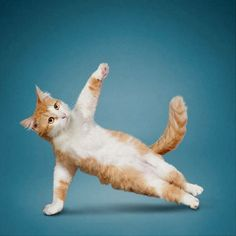

###Preconditioning of well logs



1.   The well logs could have NaN's in them.
2.   The amplitudes could be spurious.
3.   The sensor could not be functional for a given interval

These would make the analysis difficult, and ultimately incorrect. So we need to fix them. 


In [ ]:
def rolling_window(curve, window_length, func1d, step=1, return_rolled=False):
        """
        Smoother for other smoothing/conditioning functions.

        Args:
            window_length (int): the window length.
            func1d (function): a function that takes a 1D array and returns a
                scalar.
            step (int): if you want to skip samples in the shifted versions.
                Don't use this for smoothing, you will get strange results.

        Returns:
            ndarray: the resulting array.
        """
        # Force odd.
        if window_length % 2 == 0:
            window_length += 1

        shape = curve.shape[:-1] + (curve.shape[-1], window_length)
        strides = curve.strides + (step*curve.strides[-1],)
        data = np.nan_to_num(curve)
        data = np.pad(data, int(step*window_length//2), mode='edge')
        rolled = np.lib.stride_tricks.as_strided(data,
                                                 shape=shape,
                                                 strides=strides)
        result = np.apply_along_axis(func1d, -1, rolled)
        result[np.isnan(curve)] = np.nan

        if return_rolled:
            return result, rolled
        else:
            return result
            
def despike(curve, window_length=33, samples=True, z=2):
        """
        Args:
            window (int): window length in samples. Default 33 (or 5 m for
                most curves sampled at 0.1524 m intervals).
            samples (bool): window length is in samples. Use False for a window
                length given in metres.
            z (float): Z score

        Returns:
            Curve.
        """
        window_length //= 1 if samples else curve.step
        z *= np.nanstd(curve)  # Transform to curve's units
        curve_sm = rolling_window(curve,window_length, np.median)
        spikes = np.where(np.nan_to_num(curve - curve_sm) > z)[0]
        spukes = np.where(np.nan_to_num(curve_sm - curve) > z)[0]
        out = np.copy(curve)
        out[spikes] = curve_sm[spikes] + z
        out[spukes] = curve_sm[spukes] - z
        return out


def well_curve_despike(well_df,window_length=33,z=1.5):
  dfi_despike=well_df
  feature_names=list(dfi_despike.columns)[1:]
  for j in range(len(feature_names)):
    if feature_names[j]=='RT':
      dfi_despike[feature_names[j]]=np.exp(despike(np.log(np.array(dfi_despike[feature_names[j]])), window_length=window_length, samples=True, z=z))
    else:
      dfi_despike[feature_names[j]]=despike(np.array(dfi_despike[feature_names[j]]), window_length=window_length, samples=True, z=z)
  return dfi_despike

In [ ]:
well_ds_dff=well_curve_despike(well_df,window_length=50,z=2)
well_log_plot(well_ds_dff,logs)